In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_pickle('df_model')

In [3]:
df = df.dropna(subset =['final_years', 'final_make'])
df =df.drop(['make','make_title', 'year', 'years', 'title_lower', 'URL', 'bikeTitle', 'attributes',], axis =1)
df = df[df['final_years'].astype(str).str.isdigit()]
df['odometer'] = df.odometer.str.extract('(^\d*)')
df[["final_years"]] = df[['final_years']].apply(pd.to_numeric)
df['Price']= df['Price'].apply(lambda x: x.replace('$',''))
df['Price']= df['Price'].apply(lambda x: x.replace(',',''))
df[['Price']] = df[['Price']].apply(pd.to_numeric)
df[['odometer']] = df[['odometer']].apply(pd.to_numeric)
df =df.reset_index(drop=True)
df = df[df['Price']<50000]
df=df[df['Price']>600]
df = df[df['odometer']<100000]
df = df[df['final_years']>1960]
df = df[df['final_years']<2022]
df.drop("VIN", inplace =True, axis =1)
df =df.reset_index(drop=True)
df['condition'] = df['condition'].str.replace('excellentcryptocurrency ok', 'excellent')
df['condition'] = df['condition'].str.replace('like newcryptocurrency ok', 'like new')
df['condition'] = df['condition'].str.replace('goodcryptocurrency ok', 'good')
df['condition'] = df['condition'].str.replace('faircryptocurrency ok', 'fair')
df['condition'] = df['condition'].str.replace('newcryptocurrency ok', 'new')

In [4]:
df['fuel'] = df['fuel'].fillna(value='other')
df['paint color'] = df['paint color'].fillna(value='other')
df['title status'] = df['title status'].fillna(value='other')
df['transmission'] = df['transmission'].fillna(value='other')
df['condition'] = df['condition'].fillna(value='other')
df['engine displacement (CC)'] = df['engine displacement (CC)'].fillna(value='other')
df['type'] = df['type'].fillna(value='other')

In [5]:
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)

    # Return the score
    return [r2, rmse]

# Train Test Split

In [6]:
# Use train_test_split to create training data and testing data
X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Get categoricals
categoricals = ['fuel','paint color','title status', 'transmission', 'condition', 'type', 'final_make']

train_dummies = X_train[categoricals]
test_dummies = X_test[categoricals]

# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform the dataset into dummies matrix
enc = ohe.fit(train_dummies)

train_dummies_trans = enc.transform(train_dummies)
test_dummies_trans = enc.transform(test_dummies)

# Dummies values in matrix form
train_data = train_dummies_trans.todense()
test_data = test_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categoricals)

# Make them into Dataframe
train_dummies_trans_df = pd.DataFrame(train_data, columns=names)
test_dummies_trans_df = pd.DataFrame(test_data, columns=names)

In [8]:
train_dummies_trans_df = train_dummies_trans_df[train_dummies_trans_df.columns.drop(list(train_dummies_trans_df.filter(regex='other')))]
test_dummies_trans_df = test_dummies_trans_df[test_dummies_trans_df.columns.drop(list(test_dummies_trans_df.filter(regex='other')))]

In [9]:
train_dummies_trans_df.reset_index(drop=True, inplace=True)


test_dummies_trans_df.reset_index(drop=True, inplace=True)

X_train =X_train.drop(categoricals, axis=1)
X_test = X_test.drop(categoricals, axis=1)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train_comb = pd.concat([X_train, train_dummies_trans_df], axis=1)
X_test_comb = pd.concat([X_test, test_dummies_trans_df], axis=1)

In [10]:
X_train_comb = X_train_comb.drop(['title','engine displacement (CC)'],axis=1)
X_test_comb = X_test_comb.drop(['title','engine displacement (CC)'], axis=1)

In [11]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_comb,y_train)
    pred_i = knn.predict(X_test_comb)
    error_rate.append(np.mean(pred_i != y_test))


Text(0, 0.5, 'Error Rate')

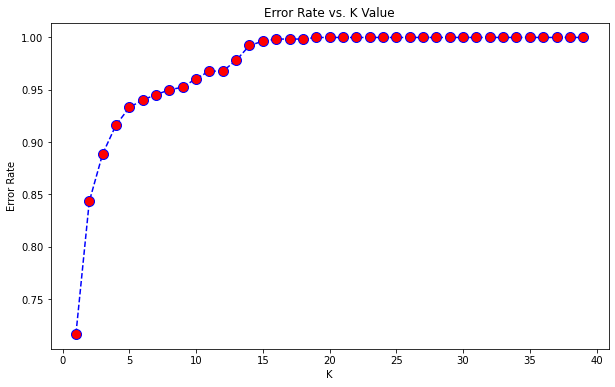

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [16]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_comb,y_train)
y_pred = knn.predict(X_test_comb)
score = performance(y_test, y_pred)
score[0], score[1], knn

(0.24530497748643487, 5569.219884777401, KNeighborsRegressor(n_neighbors=4))